# Optimization and Cosmological Constants

Much of life is an optimization problem. Crucially, optimization problems come not only objectives, but also constraints, sometimes *multiple* constraints. These constraints may be aligned, or may be at odds with one another. Let's talk about some examples!

In this course we've already seen one optimization technique: gradient descent. In this lecture we'll talk about optimization in general. This is important because gradient descent has its shortcoming, for instance it can get stuck in local minima and is not applicable in discrete problems. We'll talk about some other optimization techniques that can help us avoid these problems: simulated annealing and genetic algorithms.

# Bousso-Polchinski Model

We will apply these techniques to a problem that is very important in cosmology: the cosmological constant problem. This is the problem of why the cosmological constant is so small. In 2000, Bousso and Polchinski gave a new answer to this problem from string theory, that there is a discretuum of vacua with different values of the cosmological constant. This large discretuum (at least, to the extent that the toy model is accurate) ensures the existence of small cosmological constants in string theory, but it doesn't mean it's easy to *find* them. We'll use optimization techniques to find them.

In the Bousso-Polchinski model, we have 

$\Lambda = \Lambda_0 + N\cdot N$

where $N\in \mathbb{Z}^{h_{21}}$ is a vector of integers and $\Lambda_0 < 0$. There are many reasons that this is a toy model, but it gets the essential conceptual idea correct. The problem problem is that the observed cosmological constant in Nature is $10^{-120}$ in Planck units, and therefore the goal of the BP model is to find $N$ such that 

$0 < \Lambda < \epsilon$

One can think of this as adding up fluxes to lie in a shell slightly between spheres of radius $\Lambda_0$ and $\Lambda_0 + \epsilon$. We won't go all the way to $10^{-120}$, but we'll be happy to just get within a very thin shell.



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

L0 = 200000.1293123
# L0 = 728123.1238904512
h21 = 1000
M = 4
# M = 5

print((2**M)**2*h21)
assert (2**M)**2*h21 > L0

256000


# Random Search

This part isn't rocket science. Our vectors are 

$$N \in \mathbb{Z}^{h_{21}}$$

where the integers in the vectors are restricted to lie between $-2^M$ and $2^M$. If we pick them randomly, how do we do?

In [18]:
import numpy as np

def random_search(L0, h21, M, num_samples=10000):
    closest_vector = None
    closest_distance = float('inf')
    
    for _ in range(num_samples):
        N = np.random.randint(-2**M, 2**M+1, h21)
        distance = abs(np.linalg.norm(N)**2 - L0)
        if distance < closest_distance:
            closest_distance = distance
            closest_vector = N
    
    return closest_vector, closest_distance

N, distance = random_search(L0, h21, M)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Squared Euclidean norm: 101753.0
Distance: 98247.1293123
Percent Error: 49.12353289476489


Let's be a little more systematic.

0.4960253258506213


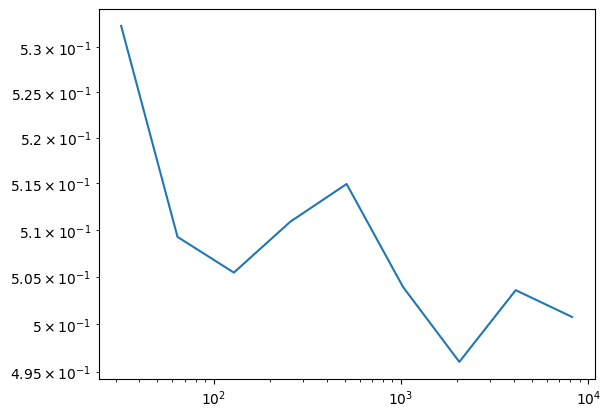

In [19]:
num_samples = [2**k for k in range(5,14)]
percent_errors = [random_search(L0, h21, M, num_samples=N)[1]/L0 for N in num_samples]

plt.plot(num_samples, percent_errors)
plt.yscale('log')
plt.xscale('log')
print(min(percent_errors))

To prove the point, let's let this go for *awhile*

In [20]:
N, distance = random_search(L0, h21, M, num_samples=10**6)
print(distance, np.dot(N,N))
print('Percent Error:', 100.*distance/L0)

96946.1293123 103054
Percent Error: 48.47303331535287


# Simulated Annealing

We can do better. We can use a technique called simulated annealing. The basic idea is to think of the problem as some energy minimization, and then slowly cool the system, introducing fluctuation in a natural way, and hoping that the "cooling" system finds a good minimum of the energy.

In this problem, we have 
$$E(N) = |N\cdot N - \Lambda_0|$$

The basic steps in the algorithm are:
- Pick a random vector $N$ at init.
- Pick a random integer $i$.
- Do something to the $i$th element of $N$, call this $N'$.
- If $E(N) > E(N')$, then accept the new vector.
- If $E(N) <> E(N')$, then accept the new vector with probability $e^{-\frac{E(N') - E(N)}{T}}$.
- Make $T$ smaller next time around.
- Iterate.

In [21]:
import numpy as np

def simulated_annealing(L0, h21, M, max_iters=10000, initial_temp=1000, cooling_rate=0.99):
    current_vector = np.random.randint(-2**M, 2**M+1, h21)
    current_distance = abs(np.linalg.norm(current_vector)**2 - L0)
    
    best_vector = np.copy(current_vector)
    best_distance = current_distance
    
    temperature = initial_temp
    
    for i in range(max_iters):
        new_vector = np.copy(current_vector)
        index_to_change = np.random.choice(h21)
        change = np.random.randint(-2, 3)
        new_vector[index_to_change] += change
        new_vector = np.clip(new_vector, -2**M, 2**M)
        
        new_distance = abs(np.linalg.norm(new_vector)**2 - L0)
        
        if new_distance < best_distance:
            best_vector = np.copy(new_vector)
            best_distance = new_distance
            
        if new_distance < current_distance or np.random.rand() < np.exp((current_distance - new_distance) / temperature):
            current_vector = np.copy(new_vector)
            current_distance = new_distance
            
        temperature *= cooling_rate
        
    return best_vector, best_distance

# L0 = 10000
# h21 = 5
# M = 10
N, distance = simulated_annealing(L0, h21, M)
print("Vector N:", N)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)


Vector N: [  8  14   8  16   9  16 -14   8  16 -14  16  12  14  16  16  10 -15 -16
 -16 -16 -16 -16 -11 -11  16 -16 -16  11 -16  16  14  16  15  16  -9   9
 -16  -9  16 -13  14  11   8  16  15  16 -11  -5 -13  16  16 -16  16 -16
 -13  10  -5   3  16  15   6  13  12  16 -16 -12  16  15  16  16 -16   8
 -14  16  15  10  12 -13  16 -16   9   1  13  16 -14 -11   9 -16 -16 -16
   9  16 -16   8  -6  16 -12 -15  13  -9  -6 -14 -13  -9  -5 -16  16 -16
 -16  -9 -16   4 -13  16 -11  11  15   5   1  10 -16 -16  13 -16 -15  14
   5  16 -16   7  12  15 -16  16  16  10  -5  13 -11 -16 -16 -12  14 -12
  15  16  12  -8   9 -16 -12  16 -13  16 -16  16 -16  16 -16 -16 -16  14
   7  -8  16 -16 -15  13  -9 -16  16  14 -16  16  -9  16  13   6 -16   7
  12 -12 -16  13  -9 -16 -15  -5 -16  -8 -13  16  13 -12 -16   8 -16 -16
   7  15 -16 -16 -16  11 -11 -14 -13 -16  16   3  16  16   4  16  16 -16
 -14   8 -13 -16  16 -16  16   9  16 -14  16  -6  16 -16  16  16 -14 -16
  12  16  16 -16  -9  16  16  16 -14 -16 

Already much better in .1s than 10s of seconds with random search. Let's crank up the number of iterations and cool more slowly.

In [22]:
N, distance = simulated_annealing(L0, h21, M, max_iters=1000000, cooling_rate=0.999)
#print("Vector N:", N)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_59011/2802165486.py:25: RuntimeWarning: overflow encountered in scalar divide
  if new_distance < current_distance or np.random.rand() < np.exp((current_distance - new_distance) / temperature):


Squared Euclidean norm: 200000.0
Distance: 0.129312300006859
Percent Error: 6.465610819927919e-05


# Genetic Algorithms

In [23]:
import numpy as np

def genetic_algorithm(L0, h21, M, population_size=100, generations=10000, mutation_rate=0.1):
    population = np.random.randint(-2**M, 2**M+1, (population_size, h21))
    
    for generation in range(generations):
        fitness = np.array([1/abs(np.linalg.norm(ind)**2 - L0) for ind in population])
        parents_indices = fitness.argsort()[-2:]
        parent1, parent2 = population[parents_indices]
        
        point = np.random.randint(1, h21-1)
        child = np.concatenate([parent1[:point], parent2[point:]]) # single point cross-over
        
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.choice(h21)
            mutation_value = np.random.randint(-2**M, 2**M+1)
            child[mutation_index] = mutation_value
        
        worst_index = fitness.argmin()
        population[worst_index] = child
        
    best_index = np.argmax([1 / (abs(np.linalg.norm(ind)**2 - L0)) for ind in population])
    best_vector = population[best_index]
    distance = abs(np.linalg.norm(best_vector)**2 - L0)
    
    return best_vector, distance

N, distance = genetic_algorithm(L0, h21, M)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)


Squared Euclidean norm: 136304.0
Distance: 63696.12931230001
Percent Error: 31.848044064430862


But don't you know that evolution takes time?

In [24]:
N, distance = genetic_algorithm(L0, h21, M, population_size=100, generations=100000, mutation_rate=0.1)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Squared Euclidean norm: 199999.0
Distance: 1.129312300006859
Percent Error: 0.0005646557849187382


# Sample and Bump

Alternatively, we can try sampling a random unit vector, putting it on the sphere, and bumping it to an integer. How does this work?

In [25]:
def sample_on_sphere(L0, h21, num_samples):
    closest_vector = None
    closest_distance = float('inf')

    for _ in range(num_samples):
        # Generate a random vector from a standard normal distribution
        random_vector = np.random.randn(h21)
        
        # Normalize the vector to get a unit vector
        unit_vector = random_vector / np.linalg.norm(random_vector)
        
        # Scale the unit vector to have a norm-squared of L0
        point_on_sphere = np.sqrt(L0) * unit_vector
        
        # Round the point to the nearest integer
        rounded_point = np.round(point_on_sphere).astype(int)
        
        # Calculate the squared Euclidean norm
        squared_norm = np.linalg.norm(rounded_point)**2

        # Calculate the distance to L0 squared
        distance = abs(squared_norm - L0)
        if distance < closest_distance:
            closest_distance = distance
            closest_vector = rounded_point
    
    return closest_vector, closest_distance


N, distance = sample_on_sphere(L0, h21, 100000)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)


Squared Euclidean norm: 200000.0
Distance: 0.129312300006859
Percent Error: 6.465610819927919e-05


Ok, so this worked better than expected. What are some downsides of this technique?

# Modified Bousso Polchinski Model

Another model, motivated by so-called type IIB string theory, is 

$\Lambda = \Lambda_0 - \frac{3}{{\cal V}^2} \left|N \cdot \Pi\right|^2$

For simplicity, let's take ${\cal V} = 1000$ and $\Pi$ sampled randomly from the unit ball.

In [29]:
L0 = 1. 
Vol = 100.
h21 = 1000

Pi = np.random.randn(h21)
Pi /= np.linalg.norm(Pi)  

mod_BP_CC = lambda N: L0 - 3./(Vol**2)* (np.dot(N,Pi))**2

In [30]:
def random_search_mod_BP(L0, h21, M, Pi, Vol, num_samples=10000):
    """
    Random search for modified BP model: Lambda = L0 - 3/Vol^2 * |N·Pi|^2
    Goal: find N such that 0 < Lambda < epsilon (small positive value)
    """
    closest_vector = None
    closest_Lambda = None
    best_score = float('inf')  # We want Lambda close to 0 but positive
    
    for _ in range(num_samples):
        N = np.random.randint(-2**M, 2**M+1, h21)
        Lambda = mod_BP_CC(N)
        
        # Score: we want Lambda close to 0, but positive
        if Lambda > 0:
            score = Lambda  # Smaller positive Lambda is better
        else:
            score = float('inf')  # Reject negative Lambda
            
        if score < best_score:
            best_score = score
            closest_Lambda = Lambda
            closest_vector = N
    
    return closest_vector, closest_Lambda

# Run random search
N, Lambda = random_search_mod_BP(L0, h21, M, Pi, Vol, num_samples=100000)
print(f"Best Lambda found: {Lambda}")
print(f"Lambda_0: {L0}")
print(f"Reduction factor: {Lambda/L0}")
print(f"N·Pi = {np.dot(N, Pi)}")

Best Lambda found: 0.3593250417270075
Lambda_0: 1.0
Reduction factor: 0.3593250417270075
N·Pi = -46.21237057588918


In [12]:
def simulated_annealing_mod_BP(L0, h21, M, Pi, Vol, max_iters=100000, initial_temp=1000, cooling_rate=0.99):
    """
    Simulated annealing for modified BP model: Lambda = L0 - 3/Vol^2 * |N·Pi|^2
    Energy function: E(N) = Lambda(N) if Lambda > 0, else large penalty
    Goal: minimize Lambda while keeping it positive
    """
    current_vector = np.random.randint(-2**M, 2**M+1, h21)
    current_Lambda = mod_BP_CC(current_vector)
    
    # Energy: we want to minimize Lambda (make it small) but keep it positive
    def energy(Lambda):
        if Lambda > 0:
            return Lambda
        else:
            return 1e10  # Large penalty for negative Lambda
    
    current_energy = energy(current_Lambda)
    
    best_vector = np.copy(current_vector)
    best_Lambda = current_Lambda
    best_energy = current_energy
    
    temperature = initial_temp
    
    for i in range(max_iters):
        new_vector = np.copy(current_vector)
        index_to_change = np.random.choice(h21)
        change = np.random.randint(-2, 3)
        new_vector[index_to_change] += change
        new_vector = np.clip(new_vector, -2**M, 2**M)
        
        new_Lambda = mod_BP_CC(new_vector)
        new_energy = energy(new_Lambda)
        
        if new_energy < best_energy:
            best_vector = np.copy(new_vector)
            best_Lambda = new_Lambda
            best_energy = new_energy
            
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            current_vector = np.copy(new_vector)
            current_Lambda = new_Lambda
            current_energy = new_energy
            
        temperature *= cooling_rate
        
    return best_vector, best_Lambda

# Run simulated annealing
N, Lambda = simulated_annealing_mod_BP(L0, h21, M, Pi, Vol, max_iters=100000, cooling_rate=0.999)
print(f"Best Lambda found: {Lambda}")
print(f"Lambda_0: {L0}")
print(f"Reduction factor: {Lambda/L0}")
print(f"N·Pi = {np.dot(N, Pi)}")
print(f"Is Lambda positive? {Lambda > 0}")

Best Lambda found: 1.0754907619370258e-05
Lambda_0: 1.0
Reduction factor: 1.0754907619370258e-05
N·Pi = 0.5773471645068735
Is Lambda positive? True


In [31]:
def genetic_algorithm_mod_BP(L0, h21, M, Pi, Vol, population_size=100, generations=10000, mutation_rate=0.1):
    """
    Genetic algorithm for modified BP model: Lambda = L0 - 3/Vol^2 * |N·Pi|^2
    Fitness: higher for smaller positive Lambda values
    """
    population = np.random.randint(-2**M, 2**M+1, (population_size, h21))
    
    def fitness(N):
        Lambda = mod_BP_CC(N)
        if Lambda > 0:
            return 1.0 / Lambda  # Higher fitness for smaller positive Lambda
        else:
            return 0.0  # Zero fitness for negative Lambda
    
    for generation in range(generations):
        # Calculate fitness for all individuals
        fitness_scores = np.array([fitness(ind) for ind in population])
        
        # Select top 2 parents
        parents_indices = fitness_scores.argsort()[-2:]
        parent1, parent2 = population[parents_indices]
        
        # Single point crossover
        point = np.random.randint(1, h21-1)
        child = np.concatenate([parent1[:point], parent2[point:]])
        
        # Mutation
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.choice(h21)
            mutation_value = np.random.randint(-2**M, 2**M+1)
            child[mutation_index] = mutation_value
        
        # Replace worst individual with child
        worst_index = fitness_scores.argmin()
        population[worst_index] = child
        
    # Find best individual in final population
    fitness_scores = np.array([fitness(ind) for ind in population])
    best_index = fitness_scores.argmax()
    best_vector = population[best_index]
    best_Lambda = mod_BP_CC(best_vector)
    
    return best_vector, best_Lambda

# Run genetic algorithm
N, Lambda = genetic_algorithm_mod_BP(L0, h21, M, Pi, Vol, population_size=100, generations=50000, mutation_rate=0.1)
print(f"Best Lambda found: {Lambda}")
print(f"Lambda_0: {L0}")
print(f"Reduction factor: {Lambda/L0}")
print(f"N·Pi = {np.dot(N, Pi)}")
print(f"Is Lambda positive? {Lambda > 0}")

Best Lambda found: 1.567567016191873e-07
Lambda_0: 1.0
Reduction factor: 1.567567016191873e-07
N·Pi = 57.73502239378621
Is Lambda positive? True
